In [1]:
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import pyaw.utils
from pyaw.configs import DATA_DIR
from pyaw.utils import get_3arrays

In [2]:
WINDOW = 50 * 20
CENTER = True
MIN_PERIODS = 1

In [3]:
fp = DATA_DIR / "swarm/magnetic_field/low_resolution1/SW_OPER_MAGA_LR_1B_12727_20160229T235551_20160301T012924.pkl"
fp_aux = DATA_DIR / "swarm/aux_/aux_SW_OPER_MAGA_LR_1B_12727_20160229T235551_20160301T012924.pkl"

df = pd.read_pickle(fp)
df_aux = pd.read_pickle(fp_aux)

bn, be, bc = get_3arrays(df['B_NEC'])
bn_mov_ave = pyaw.utils.move_average(bn, window=WINDOW, center=CENTER, min_periods=MIN_PERIODS)
bn_disturb = bn - bn_mov_ave

In [4]:
def plot_latitude_geo_qd(datetimes: np.ndarray, lats_geo, lats_qd, spacecraft, orbit_number, time_range):
    plt.figure()
    plt.plot(datetimes, lats_geo, label='Lat')
    plt.plot(datetimes, lats_qd, label='QDLat')
    plt.legend()

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))  # 每10分钟一个标签
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 时间格式为 "小时:分钟"

    plt.xlabel('Datetime')
    plt.title(f"Spacecraft {spacecraft} orbit number {orbit_number} from {time_range[0]} to {time_range[1]}")
    plt.show()
    return None

In [4]:
datetimes = df.index.values

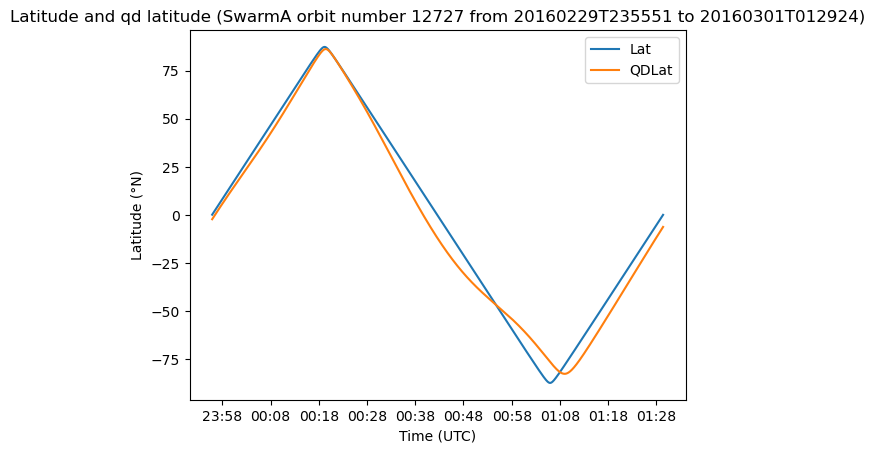

In [7]:
plt.figure()
plt.plot(datetimes, df['Latitude'].values, label='Lat')
plt.plot(datetimes, df_aux['QDLat'].values, label='QDLat')
plt.legend()

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=10))  # 每10分钟一个标签
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  # 时间格式为 "小时:分钟"

plt.xlabel('Time (UTC)')
plt.ylabel('Latitude (°N)')
plt.title(f"Latitude and qd latitude (SwarmA orbit number 12727 from 20160229T235551 to 20160301T012924)")
plt.show()

In [8]:
from scipy.signal import find_peaks

# 1. Find global extrema
max_index = np.argmax(df['Latitude'].values)  # Global maximum
min_index = np.argmin(df['Latitude'].values)  # Global minimum

print(f"Global maximum at index {max_index}, latitude: {df['Latitude'].values[max_index]}")
print(f"Global minimum at index {min_index}, latitude: {df['Latitude'].values[min_index]}")

# 2. Find local extrema (peaks and troughs)
peaks, _ = find_peaks(df['Latitude'].values)  # Local maxima
troughs, _ = find_peaks(-df['Latitude'].values)  # Local minima

print(f"Local maxima at indices {peaks}, latitudes: {df['Latitude'].values[peaks]}")
print(f"Local minima at indices {troughs}, latitudes: {df['Latitude'].values[troughs]}")

Global maximum at index 1399, latitude: 87.3523549
Global minimum at index 4206, latitude: -87.352395
Local maxima at indices [1399], latitudes: [87.3523549]
Local minima at indices [4206], latitudes: [-87.352395]


In [9]:
def plot_disturb_mag_field(datetimes: np.ndarray, field, latitudes, qdlats, mlts, spacecraft, orbit_number, time_range,
                           step=20000):
    # 创建图像
    fig, ax = plt.subplots(figsize=(18, 8))
    # 绘制数据
    ax.plot(datetimes, field, label='bn')
    plt.legend()

    max_idx_lat = np.argmax(latitudes)
    min_idx_lat = np.argmin(latitudes)
    max_idx_qdlat = np.argmax(qdlats)
    min_idx_qdlat = np.argmin(qdlats)
    max_lat = latitudes[max_idx_lat]
    min_lat = latitudes[min_idx_lat]
    max_qdlat = latitudes[max_idx_qdlat]
    min_qdlat = latitudes[min_idx_qdlat]
    max_lat_dt = datetimes[max_idx_lat]
    min_lat_dt = datetimes[min_idx_lat]
    max_qdlat_dt = datetimes[max_idx_qdlat]
    min_qdlat_dt = datetimes[min_idx_qdlat]
    # datetimes_dic = {'Latitude':[datetimes[np.argmax(latitudes)],datetimes[np.argmin(latitudes)]],
    #                  'QDLat':[datetimes[np.argmax(qdlats)],datetimes[np.argmin(qdlats)]]}
    plt.axvline(max_lat_dt, color='r', linestyle='--')
    plt.text(max_lat_dt, max(field) * 0.9, f"Lat={max_lat:.2f}", rotation=90, color='b', ha='right', va='top')
    plt.axvline(min_lat_dt, color='r', linestyle='--')
    plt.text(min_lat_dt, max(field) * 0.9, f"Lat={min_lat:.2f}", rotation=90, color='b', ha='right', va='top')

    plt.axvline(max_qdlat_dt, color='r', linestyle='--')
    plt.text(max_qdlat_dt, max(field) * 0.9, f"QDLat={max_qdlat:.2f}", rotation=90, color='b', ha='right', va='top')
    plt.axvline(min_qdlat_dt, color='r', linestyle='--')
    plt.text(min_qdlat_dt, max(field) * 0.9, f"QDLat={min_qdlat:.2f}", rotation=90, color='b', ha='right', va='top')

    # 设置时间轴标签
    datetime_ticks = datetimes[::step]
    latitude_ticks = latitudes[::step]
    qdlat_ticks = qdlats[::step]
    mlt_ticks = mlts[::step]
    ax.set_xticks(datetime_ticks)
    datetime_ticks_formatted = [t[11:19] for t in np.datetime_as_string(datetime_ticks, unit='s')]
    ax.set_xticklabels([
        f"time: {t}\nlat: {lat:.2f}°\nqdlat: {qdlat:.2f}\nmlt: {mlt:.2f}" if i == 0 else f"{t}\n{lat:.2f}\n{qdlat:.2f}\n{mlt:.2f}°"
        for i, t, lat, qdlat, mlt in
        zip(range(len(datetime_ticks_formatted)), datetime_ticks_formatted, latitude_ticks,
            qdlat_ticks, mlt_ticks)])
    plt.title(f"Spacecraft {spacecraft} orbit number {orbit_number} from {time_range[0]} to {time_range[1]}")
    plt.show()
    return None

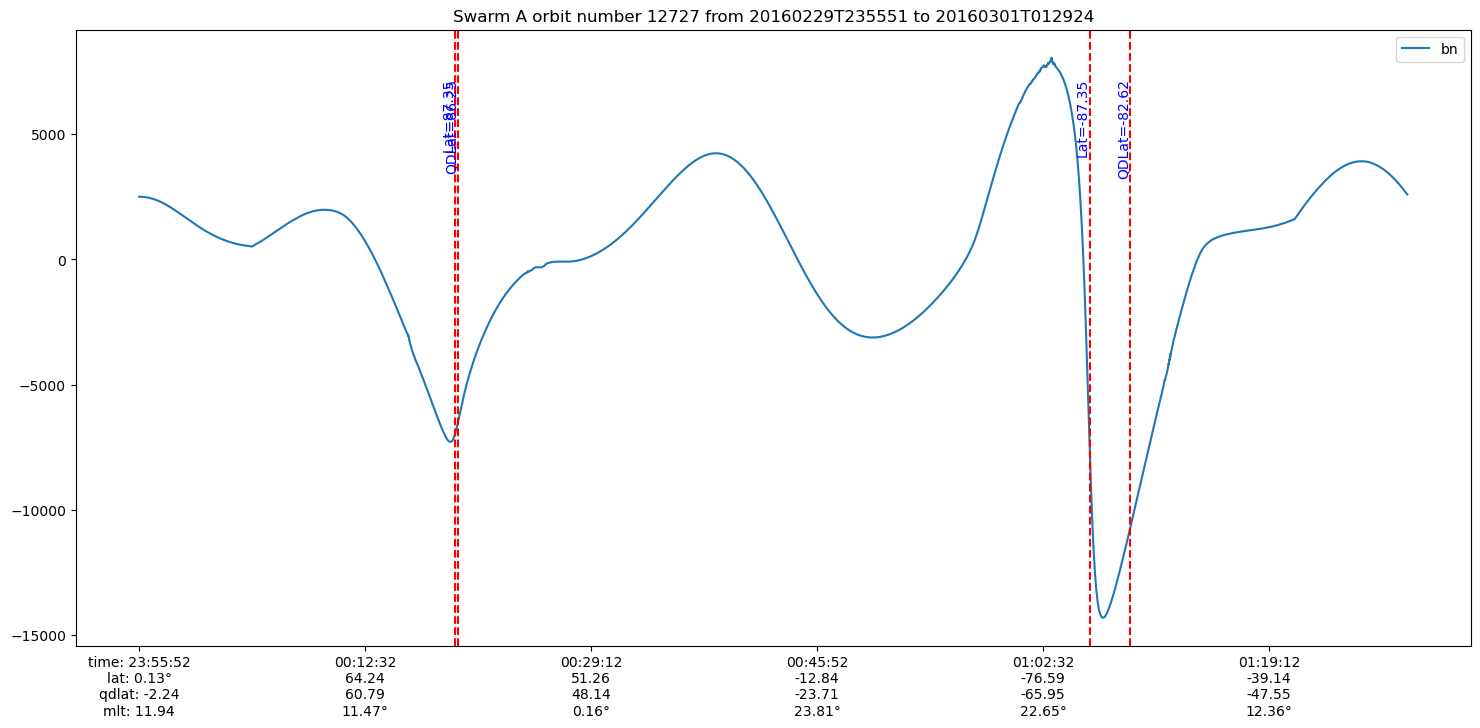

In [14]:
# 创建图像
fig, ax = plt.subplots(figsize=(18, 8))
# 绘制数据
ax.plot(datetimes, bn_disturb, label='bn')
plt.legend()

max_idx_lat = np.argmax(df['Latitude'].values)
min_idx_lat = np.argmin(df['Latitude'].values)
max_idx_qdlat = np.argmax(df_aux['QDLat'].values)
min_idx_qdlat = np.argmin(df_aux['QDLat'].values)
max_lat = df['Latitude'].values[max_idx_lat]
min_lat = df['Latitude'].values[min_idx_lat]
max_qdlat = df_aux['QDLat'].values[max_idx_qdlat]
min_qdlat = df_aux['QDLat'].values[min_idx_qdlat]
max_lat_dt = datetimes[max_idx_lat]
min_lat_dt = datetimes[min_idx_lat]
max_qdlat_dt = datetimes[max_idx_qdlat]
min_qdlat_dt = datetimes[min_idx_qdlat]
plt.axvline(max_lat_dt, color='r', linestyle='--')
plt.text(max_lat_dt, max(bn_disturb) * 0.9, f"Lat={max_lat:.2f}", rotation=90, color='b', ha='right', va='top')
plt.axvline(min_lat_dt, color='r', linestyle='--')
plt.text(min_lat_dt, max(bn_disturb) * 0.9, f"Lat={min_lat:.2f}", rotation=90, color='b', ha='right', va='top')

plt.axvline(max_qdlat_dt, color='r', linestyle='--')
plt.text(max_qdlat_dt, max(bn_disturb) * 0.9, f"QDLat={max_qdlat:.2f}", rotation=90, color='b', ha='right', va='top')
plt.axvline(min_qdlat_dt, color='r', linestyle='--')
plt.text(min_qdlat_dt, max(bn_disturb) * 0.9, f"QDLat={min_qdlat:.2f}", rotation=90, color='b', ha='right', va='top')

step = 1000
# 设置时间轴标签
datetime_ticks = datetimes[::step]
latitude_ticks = df['Latitude'].values[::step]
qdlat_ticks = df_aux['QDLat'].values[::step]
mlt_ticks = df_aux['MLT'][::step]
ax.set_xticks(datetime_ticks)
datetime_ticks_formatted = [t[11:19] for t in np.datetime_as_string(datetime_ticks, unit='s')]
ax.set_xticklabels([
    f"time: {t}\nlat: {lat:.2f}°\nqdlat: {qdlat:.2f}\nmlt: {mlt:.2f}" if i == 0 else f"{t}\n{lat:.2f}\n{qdlat:.2f}\n{mlt:.2f}°"
    for i, t, lat, qdlat, mlt in
    zip(range(len(datetime_ticks_formatted)), datetime_ticks_formatted, latitude_ticks,
        qdlat_ticks, mlt_ticks)])
plt.title(f"Swarm A orbit number 12727 from 20160229T235551 to 20160301T012924")
plt.show()